In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import crflux.models as pm
from MCEq.core import MCEqRun
from scipy.optimize import minimize_scalar
from collections import defaultdict
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

In [3]:
MC_neutrinos_dir = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Monte_Carlo_all_events_all_variables.csv"

#Giant neutrino MC db
db_MC_neutrinos = pd.read_csv(MC_neutrinos_dir)


In [4]:
db_MC_neutrinos_cut = db_MC_neutrinos[(db_MC_neutrinos['energy'] > 1)                   #at least 50 GeV (start of data from paper)
                                      & (db_MC_neutrinos['energy'] < 10000)             #at most 10 TeV
                                      & (db_MC_neutrinos['interaction_type'] != -1)     #remove undefined interaction type
                                      & (db_MC_neutrinos['interaction_type'] != 0)]      #remove non-interacting neutrinos
                                      #& (abs(db_MC_neutrinos['pid']) != 16)]            #remove tau neutrinos


In [5]:
''' Copied from https://mceq.readthedocs.io/en/latest/examples/Simple_zenith_averaged_neutrinos.html'''

mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model 
# 
# (so only cosmic rays? problem?) ^^
#
# support a tuple (primary model class (not instance!), arguments)

primary_model = (pm.HillasGaisser2012, "H3a"),

theta_deg=0.0, #we average so it doesnt matter
)

#Power of energy to scale the flux
mag = 3 #doesnt matter for ratio

#obtain energy grid (fixed) of the solution for the x-axis of the plots
e_grid = mceq_run.e_grid

#Dictionary for results
flux = {}

#Define equidistant grid in cos(theta)
angles = np.arccos(np.linspace(1,0,11))*180./np.pi

#Initialize empty grid
for frac in ['numu_total',
             'nue_total','nutau_total']:
    flux[frac] = np.zeros_like(e_grid)


#Sum fluxes, calculated for different angles
for theta in angles:
    mceq_run.set_theta_deg(theta)
    mceq_run.solve()

    flux['numu_total'] += (mceq_run.get_solution('total_numu', mag)
                          + mceq_run.get_solution('total_antinumu', mag))

    flux['nue_total'] += (mceq_run.get_solution('total_nue', mag)
                         + mceq_run.get_solution('total_antinue', mag))


    # since there are no conventional tau neutrinos, prompt=total
    flux['nutau_total'] += (mceq_run.get_solution('total_nutau', mag)
                        + mceq_run.get_solution('total_antinutau', mag))

log_bincenters = mceq_run.e_grid[(mceq_run.e_grid > 1) & (mceq_run.e_grid < 1e4)]

# log_bins are bin centers, so calculate bin edges for log spacing
log_binedges = np.sqrt(log_bincenters[:-1] * log_bincenters[1:])
log_binedges = np.concatenate(([log_bincenters[0] * (log_bincenters[1]/log_bincenters[0])**-0.5], log_binedges, [log_bincenters[-1] * (log_bincenters[-1]/log_bincenters[-2])**0.5]))  # extrapolate edges

#average the results
for frac in ['numu_total',
             'nue_total','nutau_total']:
    flux[frac] = flux[frac]/float(len(angles))
    flux[frac] = np.array([val for i, val in enumerate(flux[frac]) if e_grid[i] in log_bincenters and val != 0])


MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [6]:
track_cut = 0.46855170500726234

true_muon_to_total_list = np.zeros(len(log_bincenters))
true_muon_to_total_weighted_list = np.zeros(len(log_bincenters))

#Unweighted useful totals
NC_list = np.zeros(len(log_bincenters))
CC_list = np.zeros(len(log_bincenters))
track_list = np.zeros(len(log_bincenters))
casc_list = np.zeros(len(log_bincenters))
track_pred_list = np.zeros(len(log_bincenters))
casc_pred_list = np.zeros(len(log_bincenters))

#Weighted versions (per-bin, per-flavor weights from MCEq flux)
NC_w_list = np.zeros(len(log_bincenters))
CC_w_list = np.zeros(len(log_bincenters))
track_w_list = np.zeros(len(log_bincenters))
casc_w_list = np.zeros(len(log_bincenters))
track_pred_w_list = np.zeros(len(log_bincenters))
casc_pred_w_list = np.zeros(len(log_bincenters))

#Weighted energy distribution per flavor (for the right most plot)
mu_hist_w = np.zeros(len(log_bincenters))
e_hist_w = np.zeros(len(log_bincenters))
tau_hist_w = np.zeros(len(log_bincenters))

#Saving the weights
mu_w_list = np.zeros(len(log_bincenters))
e_w_list = np.zeros(len(log_bincenters))
tau_w_list = np.zeros(len(log_bincenters))

force_weights = True

for i in range(len(log_bincenters)):
    # Per-bin flavor weights from MCEq flux, normalized within the bin
    w_mu = float(flux['numu_total'][i]) 
    w_e  = float(flux['nue_total'][i])  
    w_tau= float(flux['nutau_total'][i])
    w_sum = w_mu + w_e + w_tau

    w_mu_n = w_mu / w_sum #normalized weights
    w_e_n  = w_e  / w_sum
    w_tau_n= w_tau / w_sum
    
    db_in_bin = db_MC_neutrinos_cut[(db_MC_neutrinos_cut['energy'] > log_binedges[i]) & (db_MC_neutrinos_cut['energy'] <= log_binedges[i+1])]

    mu_mask  = (abs(db_in_bin['pid']) == 14)
    e_mask   = (abs(db_in_bin['pid']) == 12)
    tau_mask = (abs(db_in_bin['pid']) == 16)

    if force_weights:
        # CSV composition in this bin
        w_from_csv_mu = int(mu_mask.sum())
        w_from_csv_e  = int(e_mask.sum())
        w_from_csv_tau= int(tau_mask.sum())
        
        total_from_csv = w_from_csv_mu + w_from_csv_e + w_from_csv_tau

        w_from_csv_mu_n = w_from_csv_mu / total_from_csv
        w_from_csv_e_n  = w_from_csv_e  / total_from_csv 
        w_from_csv_tau_n= w_from_csv_tau / total_from_csv 

        w_mu_n = w_mu_n / w_from_csv_mu_n
        w_e_n  = w_e_n / w_from_csv_e_n
        w_tau_n= w_tau_n / w_from_csv_tau_n

    mu_w_list[i]  = w_mu_n
    e_w_list[i]   = w_e_n
    tau_w_list[i] = w_tau_n

    #Flavor totals in this bin
    true_taus  = int(tau_mask.sum())
    true_muons = int(mu_mask.sum())
    true_elecs = int(e_mask.sum())
    denom = true_taus + true_muons + true_elecs
    true_muon_to_total_list[i] = true_muons / denom
    
    #Weighted 'CSV' muon fraction using per-flavor weights
    num_w = w_mu_n * true_muons
    den_w = w_mu_n * true_muons + w_e_n * true_elecs + w_tau_n * true_taus
    true_muon_to_total_weighted_list[i] = num_w / den_w
    
    #CC/NC totals (unweighted)
    CC = int((db_in_bin['interaction_type'] == 1).sum())
    NC = int((db_in_bin['interaction_type'] == 2).sum())
    NC_list[i] = NC
    CC_list[i] = CC

    #Track/cascade totals (unweighted truth)
    tracks = int((db_in_bin['track_mu'] == 1).sum())
    cascs  = int((db_in_bin['track_mu'] == 0).sum())
    track_list[i] = tracks
    casc_list[i]  = cascs

    #Predicted track/cascade totals (unweighted)
    track_preds = int((db_in_bin['track_mu_pred'] >= track_cut).sum())
    casc_preds  = int((db_in_bin['track_mu_pred'] <  track_cut).sum())
    track_pred_list[i] = track_preds
    casc_pred_list[i]  = casc_preds

    #Weighted CC/NC by flavor
    CC_mu  = int(((db_in_bin['interaction_type'] == 1) & mu_mask).sum())
    CC_e   = int(((db_in_bin['interaction_type'] == 1) & e_mask).sum())
    CC_tau = int(((db_in_bin['interaction_type'] == 1) & tau_mask).sum())
    NC_mu  = int(((db_in_bin['interaction_type'] == 2) & mu_mask).sum())
    NC_e   = int(((db_in_bin['interaction_type'] == 2) & e_mask).sum())
    NC_tau = int(((db_in_bin['interaction_type'] == 2) & tau_mask).sum())
    CC_w_list[i] = CC_mu*w_mu_n + CC_e*w_e_n + CC_tau*w_tau_n
    NC_w_list[i] = NC_mu*w_mu_n + NC_e*w_e_n + NC_tau*w_tau_n

    #Weighted track/cascade by flavor (truth)
    tr_mu  = int(((db_in_bin['track_mu'] == 1) & mu_mask).sum())
    tr_e   = int(((db_in_bin['track_mu'] == 1) & e_mask).sum())
    tr_tau = int(((db_in_bin['track_mu'] == 1) & tau_mask).sum())
    ca_mu  = int(((db_in_bin['track_mu'] == 0) & mu_mask).sum())
    ca_e   = int(((db_in_bin['track_mu'] == 0) & e_mask).sum())
    ca_tau = int(((db_in_bin['track_mu'] == 0) & tau_mask).sum())
    track_w_list[i] = tr_mu*w_mu_n + tr_e*w_e_n + tr_tau*w_tau_n
    casc_w_list[i]  = ca_mu*w_mu_n + ca_e*w_e_n + ca_tau*w_tau_n

    #Weighted predicted track/cascade by flavor
    trp_mu  = int(((db_in_bin['track_mu_pred'] >= track_cut) & mu_mask).sum())
    trp_e   = int(((db_in_bin['track_mu_pred'] >= track_cut) & e_mask).sum())
    trp_tau = int(((db_in_bin['track_mu_pred'] >= track_cut) & tau_mask).sum())
    cap_mu  = int(((db_in_bin['track_mu_pred'] <  track_cut) & mu_mask).sum())
    cap_e   = int(((db_in_bin['track_mu_pred'] <  track_cut) & e_mask).sum())
    cap_tau = int(((db_in_bin['track_mu_pred'] <  track_cut) & tau_mask).sum())
    track_pred_w_list[i] = trp_mu*w_mu_n + trp_e*w_e_n + trp_tau*w_tau_n
    casc_pred_w_list[i]  = cap_mu*w_mu_n + cap_e*w_e_n + cap_tau*w_tau_n

    #Weighted energy distribution per flavor (for the new right-most plot)
    mu_hist_w[i]  = w_mu_n  * true_muons
    e_hist_w[i]   = w_e_n   * true_elecs
    tau_hist_w[i] = w_tau_n * true_taus


#should I force the weights to be such that each flavour has the same frequency as expected from MCEq?

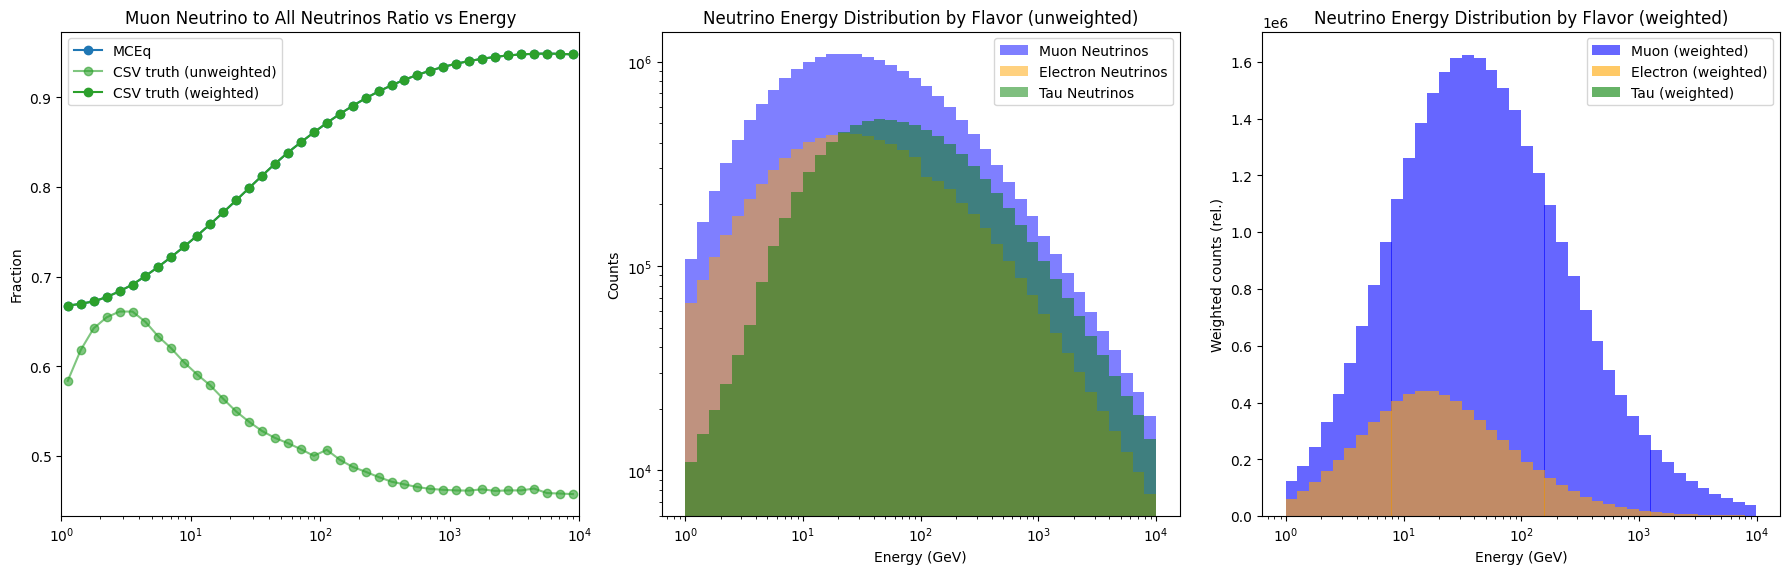

In [7]:
mu_to_all = flux['numu_total']/(flux['nue_total']+flux['numu_total']+flux['nutau_total'])

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Left: muon fraction comparison
ax[0].plot(log_bincenters, mu_to_all, marker='o', label='MCEq', color='tab:blue')
ax[0].plot(log_bincenters, true_muon_to_total_list, marker='o', label='CSV truth (unweighted)', color='tab:green', alpha=0.6)
ax[0].plot(log_bincenters, true_muon_to_total_weighted_list, marker='o', label='CSV truth (weighted)', color='tab:green')
ax[0].set_ylabel('Fraction')
ax[0].set_title('Muon Neutrino to All Neutrinos Ratio vs Energy')
ax[0].set_xlim([1, 10000])
ax[0].set_xscale('log')
ax[0].legend()

# Middle: unweighted energy distributions
bins = np.logspace(np.log10(db_MC_neutrinos_cut['energy'].min()), np.log10(db_MC_neutrinos_cut['energy'].max()), 41)
ax[1].set_xscale('log')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 14]['energy'], bins=bins, alpha=0.5, label='Muon Neutrinos', color='blue')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 12]['energy'], bins=bins, alpha=0.5, label='Electron Neutrinos', color='orange')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 16]['energy'], bins=bins, alpha=0.5, label='Tau Neutrinos', color='green')
ax[1].set_xlabel('Energy (GeV)')
ax[1].set_yscale('log')
ax[1].set_ylabel('Counts')
ax[1].set_title('Neutrino Energy Distribution by Flavor (unweighted)')
ax[1].legend()

# Right: weighted per-flavor distributions (bar plot per bin)
# Compute per-bin widths from the precomputed bin edges; this yields one width per center
bin_widths = np.diff(log_binedges)
ax[2].bar(log_bincenters, mu_hist_w, width=bin_widths, alpha=0.6, label='Muon (weighted)', color='blue', align='center')
ax[2].bar(log_bincenters, e_hist_w,  width=bin_widths, alpha=0.6, label='Electron (weighted)', color='orange', align='center')
ax[2].bar(log_bincenters, tau_hist_w, width=bin_widths, alpha=0.6, label='Tau (weighted)', color='green', align='center')
ax[2].set_xscale('log')
ax[2].set_xlabel('Energy (GeV)')
ax[2].set_ylabel('Weighted counts (rel.)')
ax[2].set_title('Neutrino Energy Distribution by Flavor (weighted)')
ax[2].legend()

plt.tight_layout()
plt.show()

In [8]:
# Build per-event weights from per-bin per-flavor weights
# Map each event to its energy bin and flavor, then assign corresponding weight.
edges = log_binedges
energies = db_MC_neutrinos_cut['energy'].values
pids_abs = np.abs(db_MC_neutrinos_cut['pid'].values)

bin_idx = np.digitize(energies, edges) - 1
# Clip to valid bin range
bin_idx = np.clip(bin_idx, 0, len(mu_w_list) - 1)

event_weight = np.ones_like(energies, dtype=float)

mu_mask_ev = (pids_abs == 14)
e_mask_ev  = (pids_abs == 12)
tau_mask_ev= (pids_abs == 16)

event_weight[mu_mask_ev]  = mu_w_list[bin_idx[mu_mask_ev]]
event_weight[e_mask_ev]   = e_w_list[bin_idx[e_mask_ev]]
event_weight[tau_mask_ev] = tau_w_list[bin_idx[tau_mask_ev]]

print(f"Built per-event weights. Mean={event_weight.mean():.3f}, min={event_weight.min():.3g}, max={event_weight.max():.3g}")

Built per-event weights. Mean=1.000, min=8.6e-07, max=2.07


Index(['track_mu_pred', 'event_no', 'track_mu', 'energy_pred', 'energy',
       'zenith_pred', 'zenith_kappa', 'zenith', 'azimuth_pred',
       'azimuth_kappa', 'azimuth', 'pid_noise_pred', 'pid_muon_pred',
       'pid_neutrino_pred', 'pid', 'pid_neutrino_pred_logit',
       'position_x_pred', 'position_y_pred', 'position_z_pred', 'position_x',
       'position_y', 'position_z', 'N_pulses', 'N_string', 'N_doms',
       'First_dom_time', 'C2HR6', 'CausalVetoHits', 'CleanedFullTimeLength',
       'DCFiducialHits', 'L3_oscNext_bool', 'NAbove200Hits', 'NchCleaned',
       'NoiseEngineNoCharge', 'RTVetoCutHit', 'STW9000_DTW300Hits',
       'UncleanedFullTimeLength', 'VertexGuessZ', 'VetoFiducialRatioHits',
       'interaction_type', 'total_osc_weight'],
      dtype='object')


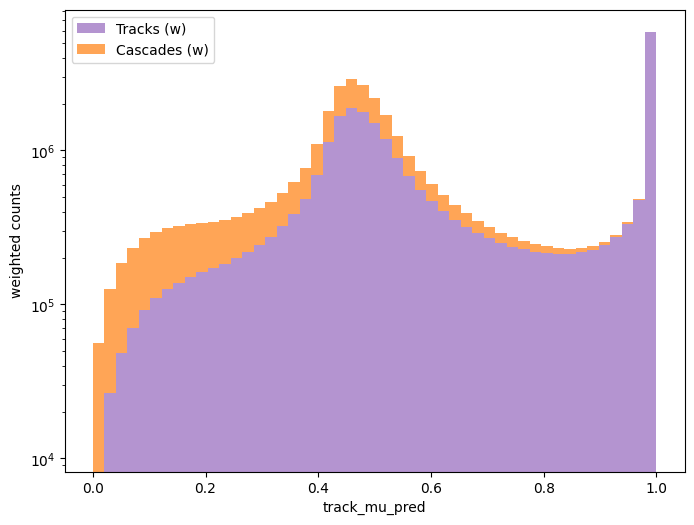

In [9]:
print(db_MC_neutrinos_cut.columns)

casc_mask = (db_MC_neutrinos_cut['track_mu'] == 0)
track_mask = (db_MC_neutrinos_cut['track_mu'] == 1)

data_list = [db_MC_neutrinos_cut.loc[casc_mask, 'track_mu_pred'].values,
             db_MC_neutrinos_cut.loc[track_mask, 'track_mu_pred'].values]

labels = ['Cascades', 'Tracks']
colors = ['tab:orange', 'tab:purple']

fig, ax = plt.subplots(figsize=(8,6))

bins = np.linspace(0, 1, 50)

# Weighted histograms by per-event weights
hist_casc, _ = np.histogram(data_list[0], bins=bins, weights=event_weight[casc_mask])
hist_track, _ = np.histogram(data_list[1], bins=bins, weights=event_weight[track_mask])

bin_centers = 0.5 * (bins[1:] + bins[:-1])
bin_widths = bins[1] - bins[0]

ax.bar(bin_centers, hist_track, width=bin_widths, color=colors[1], alpha=0.7, label=labels[1] + ' (w)')
ax.bar(bin_centers, hist_casc, width=bin_widths, bottom=hist_track, color=colors[0], alpha=0.7, label=labels[0] + ' (w)')

ax.set_yscale('log')
ax.set_xlabel('track_mu_pred')
ax.set_ylabel('weighted counts')
ax.legend()

plt.show()

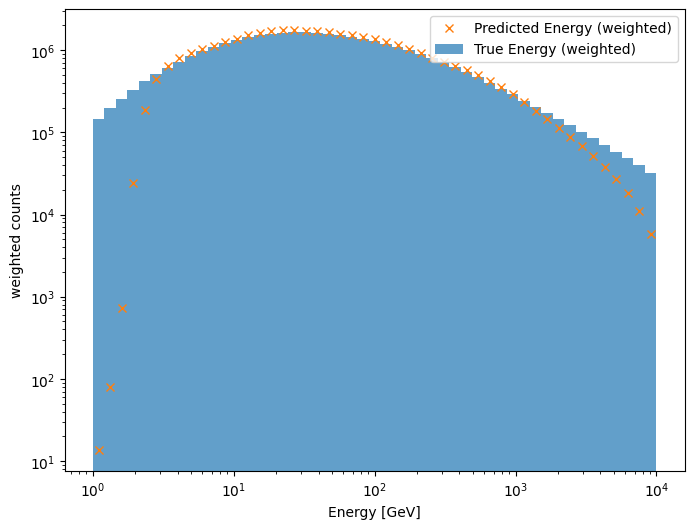

In [10]:
fig, ax = plt.subplots(figsize=(8,6))

bins = np.logspace(np.log10(db_MC_neutrinos_cut['energy'].min()), np.log10(db_MC_neutrinos_cut['energy'].max()), 50)

bins_center = 0.5 * (bins[1:] + bins[:-1])

# Weighted histograms for true and predicted energy
hist_true_w, _ = np.histogram(db_MC_neutrinos_cut['energy'], bins=bins, weights=event_weight)
hist_pred_w, _ = np.histogram(db_MC_neutrinos_cut['energy_pred'], bins=bins, weights=event_weight)

ax.bar(bins_center, hist_true_w, width=np.diff(bins), color='tab:blue', alpha=0.7, label='True Energy (weighted)', align='center')
ax.plot(bins_center, hist_pred_w, 'x', color='tab:orange', label='Predicted Energy (weighted)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy [GeV]')
ax.set_ylabel('weighted counts')
ax.legend()

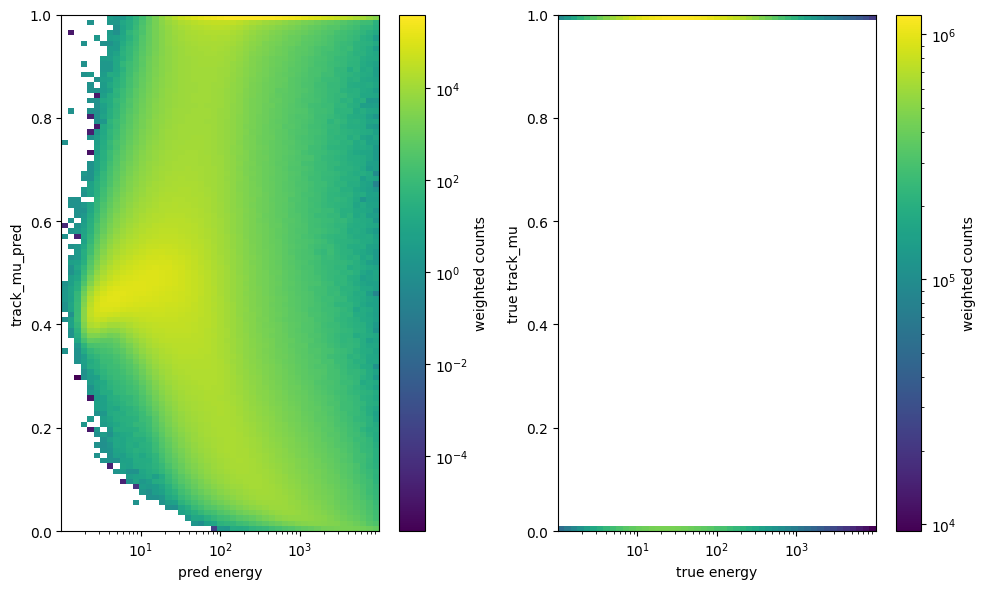

In [11]:
# 2D density plot (weighted): true energy vs track_mu_pred
x = db_MC_neutrinos_cut['energy_pred'].values
y = db_MC_neutrinos_cut['track_mu_pred'].values

x2 = db_MC_neutrinos_cut['energy'].values
y2 = db_MC_neutrinos_cut['track_mu'].values

# reuse existing 'bins' if available (log-spaced energy bins), otherwise create
try:
    energy_bins = bins
except NameError:
    energy_bins = np.logspace(np.log10(x.min()), np.log10(x.max()), 50)

y_bins = np.linspace(0.0, 1.0, 100)

# Weighted 2D histograms
H, xedges, yedges = np.histogram2d(x, y, bins=[energy_bins, y_bins], weights=event_weight)
H2, xedges2, yedges2 = np.histogram2d(x2, y2, bins=[energy_bins, y_bins], weights=event_weight)

def make_norm(H):
    pos = H[H > 0]
    vmin = float(pos.min()) if pos.size else 1e-6
    vmin = max(vmin, 1e-6)
    vmax = float(H.max()) if H.size else 1.0
    vmax = max(vmax, vmin * 10)
    return LogNorm(vmin=vmin, vmax=vmax)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
pcm = ax1.pcolormesh(xedges, yedges, H.T, norm=make_norm(H), cmap='viridis')
pcm2 = ax2.pcolormesh(xedges2, yedges2, H2.T, norm=make_norm(H2), cmap='viridis')

ax1.set_xscale('log')
ax1.set_ylabel('track_mu_pred')
ax1.set_xlabel('pred energy')
ax1.set_ylim(0, 1)

ax2.set_xscale('log')
ax2.set_ylabel('true track_mu')
ax2.set_xlabel('true energy')
ax2.set_ylim(0, 1)

cbar = fig.colorbar(pcm, ax=ax1)
cbar.set_label('weighted counts')

cbar2 = fig.colorbar(pcm2, ax=ax2)
cbar2.set_label('weighted counts')

plt.tight_layout()
plt.show()

[INFO] Selected TRUE bin (weighted): E∈[1.16e+03±108] → [1.05e+03,1.26e+03),  track∈[0.995±0.005] → [0.990,1.000] with N=89107 events


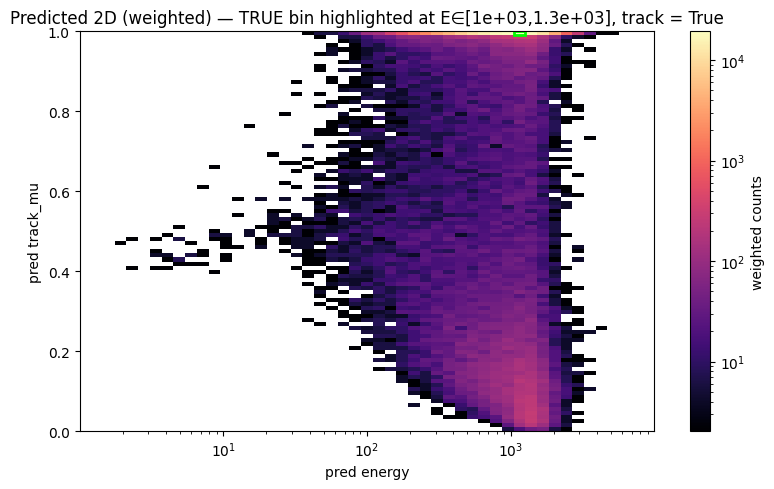

In [15]:
# Select a random non-empty cell from the TRUE 2D histogram (energy vs track_mu)
# and plot the 2D histogram of PREDICTED energy vs predicted track for those events (weighted)
# Prepare bins consistent with earlier cell
try:
    energy_bins = bins  # if earlier defined
except NameError:
    # Derive log-spaced bins from predicted energy like before
    e_pred = db_MC_neutrinos_cut['energy_pred'].values
    energy_bins = np.logspace(np.log10(max(e_pred.min(), 1e-6)), np.log10(e_pred.max()), 50)

true_y_bins = np.linspace(0.0, 1.0, 100)

# True quantities
E_true = db_MC_neutrinos_cut['energy'].values
T_true = db_MC_neutrinos_cut['track_mu'].values  # 0 or 1

# Build TRUE 2D histogram (weighted) and pick a random non-empty bin
H_true, E_edges, T_edges = np.histogram2d(E_true, T_true, bins=[energy_bins, true_y_bins], weights=event_weight)
nonzero = np.argwhere(H_true > 0)
if len(nonzero) == 0:
    raise RuntimeError("No non-empty bins found in weighted true 2D histogram.")
idx = np.random.randint(0, len(nonzero))
I_e, I_t = nonzero[idx]

# Compute bin centers and widths, then use center ± 0.5*width for selection
E_lo_edge, E_hi_edge = E_edges[I_e], E_edges[I_e + 1]
T_lo_edge, T_hi_edge = T_edges[I_t], T_edges[I_t + 1]
E_center = 0.5 * (E_lo_edge + E_hi_edge)
T_center = 0.5 * (T_lo_edge + T_hi_edge)
E_width = (E_hi_edge - E_lo_edge)
T_width = (T_hi_edge - T_lo_edge)
E_lo = E_center - 0.5 * E_width
E_hi = E_center + 0.5 * E_width
T_lo = T_center - 0.5 * T_width
T_hi = T_center + 0.5 * T_width

# Make last-bin upper bound inclusive to mirror histogram2d behavior
is_last_E_bin = (I_e == len(E_edges) - 2)
is_last_T_bin = (I_t == len(T_edges) - 2)

if is_last_E_bin and is_last_T_bin:
    sel_mask = (
        (db_MC_neutrinos_cut['energy'].values >= E_lo) & (db_MC_neutrinos_cut['energy'].values <= E_hi) &
        (db_MC_neutrinos_cut['track_mu'].values >= T_lo) & (db_MC_neutrinos_cut['track_mu'].values <= T_hi)
    )
elif is_last_E_bin:
    sel_mask = (
        (db_MC_neutrinos_cut['energy'].values >= E_lo) & (db_MC_neutrinos_cut['energy'].values <= E_hi) &
        (db_MC_neutrinos_cut['track_mu'].values >= T_lo) & (db_MC_neutrinos_cut['track_mu'].values <  T_hi)
    )
elif is_last_T_bin:
    sel_mask = (
        (db_MC_neutrinos_cut['energy'].values >= E_lo) & (db_MC_neutrinos_cut['energy'].values <  E_hi) &
        (db_MC_neutrinos_cut['track_mu'].values >= T_lo) & (db_MC_neutrinos_cut['track_mu'].values <= T_hi)
    )
else:
    sel_mask = (
        (db_MC_neutrinos_cut['energy'].values >= E_lo) & (db_MC_neutrinos_cut['energy'].values <  E_hi) &
        (db_MC_neutrinos_cut['track_mu'].values >= T_lo) & (db_MC_neutrinos_cut['track_mu'].values <  T_hi)
    )

# Extract predicted values and weights for the selected TRUE bin
E_pred_sel = db_MC_neutrinos_cut.loc[sel_mask, 'energy_pred'].values
T_pred_sel = db_MC_neutrinos_cut.loc[sel_mask, 'track_mu_pred'].values
weights_sel = event_weight[sel_mask]
n_sel = E_pred_sel.size
print(
    f"[INFO] Selected TRUE bin (weighted): E∈[{E_center:.3g}±{0.5*E_width:.3g}] → [{E_lo:.3g},{E_hi:.3g}), ",
    f"track∈[{T_center:.3f}±{0.5*T_width:.3f}] → [{T_lo:.3f},{T_hi:.3f}] with N={n_sel} events"
 )

if n_sel == 0:
    raise RuntimeError("Randomly selected TRUE bin contained 0 events after masking.")

# Build PREDICTED 2D histogram for those events (weighted)
pred_y_bins = np.linspace(0.0, 1.0, 100)
H_pred, E_edges_pred, T_edges_pred = np.histogram2d(E_pred_sel, T_pred_sel, bins=[energy_bins, pred_y_bins], weights=weights_sel)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

def make_norm(H):
    pos = H[H > 0]
    vmin = float(pos.min()) if pos.size else 1e-6
    vmin = max(vmin, 1e-6)
    vmax = float(H.max()) if H.size else 1.0
    vmax = max(vmax, vmin * 10)
    return LogNorm(vmin=vmin, vmax=vmax)

pcm = ax.pcolormesh(E_edges_pred, T_edges_pred, H_pred.T, norm=make_norm(H_pred), cmap='magma')
ax.set_xscale('log')
ax.set_xlabel('pred energy')
ax.set_ylabel('pred track_mu')
ax.set_ylim(0, 1)

# Overlay the ORIGINAL TRUE bin (in true-energy/true-track space) as a green rectangle
# Note: energy_bins are shared for true/pred x-axis, and y in [0, 1] for both, so overlay is meaningful.
true_rect = Rectangle(
    (E_lo_edge, T_lo_edge),
    E_hi_edge - E_lo_edge,
    T_hi_edge - T_lo_edge,
    fill=False,
    edgecolor='lime',
    linewidth=2,
)
ax.add_patch(true_rect)

cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('weighted counts')
ax.set_title(
    f"Predicted 2D (weighted) — TRUE bin highlighted at E∈[{E_lo_edge:.2g},{E_hi_edge:.2g}], track = {'False' if T_lo_edge == 0 else 'True'}"
)
plt.tight_layout()
plt.show()

In [25]:
# Resample predicted (energy_pred, track_mu_pred) per TRUE bin for every event
# Weighted sampling: use per-event weights and boost NC events by factor R
# For each event, determined by its TRUE (energy bin, track bin), draw one random
# pair from the predicted distribution of all events in the same TRUE bin.
# Results are stored in new columns of a returned DataFrame.

# Bin edges for TRUE track (0 vs 1)
true_track_edges = np.array([0.0, 0.5, 1.0 + 1e-9])


def resample_predictions_per_true_bin_weighted(df, energy_bins, true_track_edges,
                                               base_weights=None, R_factor=None,
                                               rng_seed=None):
    """
    Resample (energy_pred, track_mu_pred) for each event from peers in the same TRUE bin,
    using weighted sampling. Weights are base_weights multiplied by R_factor for NC events.

    - df: DataFrame with columns ['energy','track_mu','energy_pred','track_mu_pred','interaction_type']
    - energy_bins: array of true-energy bin edges
    - true_track_edges: array of true-track bin edges (e.g., [0, 0.5, 1])
    - base_weights: per-event weights (e.g., event_weight). If None, uniform.
    - R_factor: scalar multiplier for NC (interaction_type == 2). If None, try globals():
        * if R exists and is finite, use it
        * elif sin2w_current exists, compute via scale_sigma_NC(1.0, sin2w_current)
        * else default to 1.0
    - rng_seed: optional seed for reproducibility.

    Returns: new_df (copy of df) with two new columns:
      * 'energy_pred_resampled'
      * 'track_mu_pred_resampled'
    """
    E_true = df['energy'].to_numpy()
    T_true = df['track_mu'].to_numpy()
    E_pred = df['energy_pred'].to_numpy()
    T_pred = df['track_mu_pred'].to_numpy()
    itype  = df['interaction_type'].to_numpy()

    # Base weights
    if base_weights is None:
        w_base = np.ones_like(E_true, dtype=float)
    else:
        w_base = np.asarray(base_weights, dtype=float)
        if w_base.shape[0] != E_true.shape[0]:
            raise ValueError('base_weights must have same length as df')

    # Determine R_factor
    R_used = None
    if R_factor is not None and np.isfinite(R_factor):
        R_used = float(R_factor)
    else:
        R_used = 1.0

    # Compute TRUE bin indices
    nb_e = len(energy_bins) - 1
    nb_t = len(true_track_edges) - 1
    idx_e = np.digitize(E_true, energy_bins) - 1
    idx_t = np.digitize(T_true, true_track_edges) - 1

    # Valid mask (inside both bin ranges and finite values)
    valid = (
        (idx_e >= 0) & (idx_e < nb_e) &
        (idx_t >= 0) & (idx_t < nb_t) &
        np.isfinite(E_true) & np.isfinite(T_true) &
        np.isfinite(E_pred) & np.isfinite(T_pred) &
        np.isfinite(w_base) & np.isfinite(itype)
    )

    # Group indices by (energy-bin, track-bin)
    bin_groups = defaultdict(list)
    for i, ok in enumerate(valid):
        if ok:
            bin_groups[(int(idx_e[i]), int(idx_t[i]))].append(i)

    # Prepare output arrays
    E_pred_res = np.full_like(E_pred, np.nan, dtype=float)
    T_pred_res = np.full_like(T_pred, np.nan, dtype=float)

    rng = np.random.default_rng(rng_seed)

    # Sample within each group: one draw per event in the group
    for inds in bin_groups.values():
        inds = np.asarray(inds, dtype=int)

        # Candidate pool to sample FROM is the same group
        pool = inds

        # Build sampling weights for pool: base * (R if NC else 1)
        pool_w = w_base[pool].astype(float)
        nc_mask_pool = (itype[pool] == 2)
        pool_w = pool_w * np.where(nc_mask_pool, R_used, 1.0)

        # If all weights are zero or non-finite, fallback to uniform
        if not np.all(np.isfinite(pool_w)) or pool_w.sum() <= 0:
            p = None
        else:
            p = pool_w / pool_w.sum()

        # Draw one index from pool for each event in group
        chosen = rng.choice(pool, size=inds.size, replace=True, p=p)

        # Assign sampled predictions to each event in the group
        E_pred_res[inds] = E_pred[chosen]
        T_pred_res[inds] = T_pred[chosen]

    # Build new DataFrame and persist
    new_df = df.copy()
    new_df['energy_pred_resampled'] = E_pred_res
    new_df['track_mu_pred_resampled'] = T_pred_res

    print(f"[INFO] Resampled predictions for {int(valid.sum())} events across {len(bin_groups)} true bins using R={R_used:.4g} for NC boost.")
    return new_df, R_used


# Execute weighted resampling with NC boost by R
resampled_db, R_used = resample_predictions_per_true_bin_weighted(
    db_MC_neutrinos_cut,
    energy_bins,
    true_track_edges,
    base_weights=event_weight,
    R_factor=None,           # pass a number to override; None will auto-discover
    rng_seed=None            # set an int for reproducibility
)

[INFO] Resampled predictions for 36741821 events across 98 true bins using R=1 for NC boost.


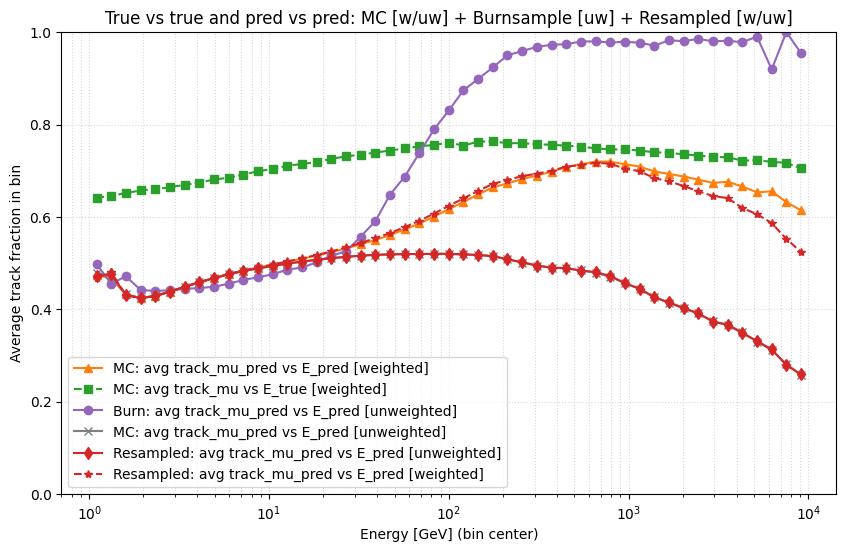

In [17]:
# Compute MC curves: (1) true vs true (weighted), (2) pred vs pred (weighted)// and add Burnsample curves: (3) pred vs pred (unweighted), (4) true vs true (unweighted, if available)

# Energy bin edges from earlier; otherwise, build from MC predicted energy as fallback

nb = len(energy_bins) - 1
energy_centers = np.sqrt(energy_bins[:-1] * energy_bins[1:])  # geometric mean for log bins

# (1) MC (weighted): avg TRUE track_mu vs TRUE energy
e_true_mc = db_MC_neutrinos_cut['energy'].to_numpy()
t_true_mc = db_MC_neutrinos_cut['track_mu'].to_numpy()
w_mc      = event_weight  # per-event weights aligned with db_MC_neutrinos_cut
idx_true  = np.digitize(e_true_mc, energy_bins) - 1
mask_true = (idx_true >= 0) & (idx_true < nb) & np.isfinite(e_true_mc) & np.isfinite(t_true_mc) & np.isfinite(w_mc)
sum_wt_true = np.bincount(idx_true[mask_true], weights=t_true_mc[mask_true] * w_mc[mask_true], minlength=nb)[:nb]
sum_w_true  = np.bincount(idx_true[mask_true], weights=w_mc[mask_true], minlength=nb)[:nb]
avg_true_true = np.divide(sum_wt_true, sum_w_true, out=np.full(nb, np.nan, dtype=float), where=sum_w_true > 0)

# (2) MC (weighted): avg PRED track_mu_pred vs PRED energy_pred
e_pred_mc = db_MC_neutrinos_cut['energy_pred'].to_numpy()
t_pred_mc = db_MC_neutrinos_cut['track_mu_pred'].to_numpy()
idx_pred  = np.digitize(e_pred_mc, energy_bins) - 1
mask_pred = (idx_pred >= 0) & (idx_pred < nb) & np.isfinite(e_pred_mc) & np.isfinite(t_pred_mc) & np.isfinite(w_mc)
sum_wt_pred = np.bincount(idx_pred[mask_pred], weights=t_pred_mc[mask_pred] * w_mc[mask_pred], minlength=nb)[:nb]
sum_w_pred  = np.bincount(idx_pred[mask_pred], weights=w_mc[mask_pred], minlength=nb)[:nb]
avg_pred_pred = np.divide(sum_wt_pred, sum_w_pred, out=np.full(nb, np.nan, dtype=float), where=sum_w_pred > 0)

# (2b) MC (unweighted): avg PRED track_mu_pred vs PRED energy_pred (for apples-to-apples with resampled unweighted)
sum_t_pred_uw = np.bincount(idx_pred[mask_pred], weights=t_pred_mc[mask_pred], minlength=nb)[:nb]
cnt_pred_uw   = np.bincount(idx_pred[mask_pred], minlength=nb)[:nb]
avg_pred_pred_uw = np.divide(sum_t_pred_uw, cnt_pred_uw, out=np.full(nb, np.nan, dtype=float), where=cnt_pred_uw > 0)

# (3) Burnsample (unweighted): avg track_mu_pred vs energy_pred
filepath = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Burnsample_1_percent_all_events_all_variables.csv"
df_burn = pd.read_csv(filepath, nrows=100000)
e_pred_burn = df_burn['energy_pred'].to_numpy()
t_pred_burn = df_burn['track_mu_pred'].to_numpy()
idx_burn_pred = np.digitize(e_pred_burn, energy_bins) - 1
mask_burn_pred = (idx_burn_pred >= 0) & (idx_burn_pred < nb) & np.isfinite(e_pred_burn) & np.isfinite(t_pred_burn)
sum_t_burn_pred = np.bincount(idx_burn_pred[mask_burn_pred], weights=t_pred_burn[mask_burn_pred], minlength=nb)[:nb]
cnt_burn_pred   = np.bincount(idx_burn_pred[mask_burn_pred], minlength=nb)[:nb]
avg_burn_pred   = np.divide(sum_t_burn_pred, cnt_burn_pred, out=np.full(nb, np.nan, dtype=float), where=cnt_burn_pred > 0)

# (5) Resampled new_db (unweighted and weighted): avg track_mu_pred_resampled vs energy_pred_resampled, if available
avg_resampled = None
avg_resampled_w = None

new_db = resampled_db  # check variable exists

# Unweighted resampled
e_pred_rs = new_db['energy_pred_resampled'].to_numpy()
t_pred_rs = new_db['track_mu_pred_resampled'].to_numpy()
idx_rs = np.digitize(e_pred_rs, energy_bins) - 1
mask_rs = (idx_rs >= 0) & (idx_rs < nb) & np.isfinite(e_pred_rs) & np.isfinite(t_pred_rs)
sum_t_rs = np.bincount(idx_rs[mask_rs], weights=t_pred_rs[mask_rs], minlength=nb)[:nb]
cnt_rs   = np.bincount(idx_rs[mask_rs], minlength=nb)[:nb]
avg_resampled = np.divide(sum_t_rs, cnt_rs, out=np.full(nb, np.nan, dtype=float), where=cnt_rs > 0)

# Weighted resampled (attach each resampled pair to the recipient event's weight w_mc)
sum_wt_rs = np.bincount(idx_rs[mask_rs], weights=t_pred_rs[mask_rs] * w_mc[mask_rs], minlength=nb)[:nb]
sum_w_rs  = np.bincount(idx_rs[mask_rs], weights=w_mc[mask_rs], minlength=nb)[:nb]
avg_resampled_w = np.divide(sum_wt_rs, sum_w_rs, out=np.full(nb, np.nan, dtype=float), where=sum_w_rs > 0)

# Plot
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(energy_centers, avg_pred_pred, marker='^', linestyle='-',  color='tab:orange', label='MC: avg track_mu_pred vs E_pred [weighted]')
ax.plot(energy_centers, avg_true_true, marker='s', linestyle='--', color='tab:green',  label='MC: avg track_mu vs E_true [weighted]')
ax.plot(energy_centers, avg_burn_pred, marker='o', linestyle='-',  color='tab:purple', label='Burn: avg track_mu_pred vs E_pred [unweighted]')
ax.plot(energy_centers, avg_pred_pred_uw, marker='x', linestyle='-', color='gray', label='MC: avg track_mu_pred vs E_pred [unweighted]')
ax.plot(energy_centers, avg_resampled, marker='d', linestyle='-', color='tab:red', label='Resampled: avg track_mu_pred vs E_pred [unweighted]')
ax.plot(energy_centers, avg_resampled_w, marker='*', linestyle='--', color='tab:red', label='Resampled: avg track_mu_pred vs E_pred [weighted]')

ax.set_xscale('log')
ax.set_ylim(0, 1)
ax.set_xlabel('Energy [GeV] (bin center)')
ax.set_ylabel('Average track fraction in bin')
ax.set_title('True vs true and pred vs pred: MC [w/uw] + Burnsample [uw] + Resampled [w/uw]')
ax.grid(True, which='both', ls=':', alpha=0.5)
ax.legend()
plt.show()

#The combined smear of energy and trackness makes MC and Burnsample line up better

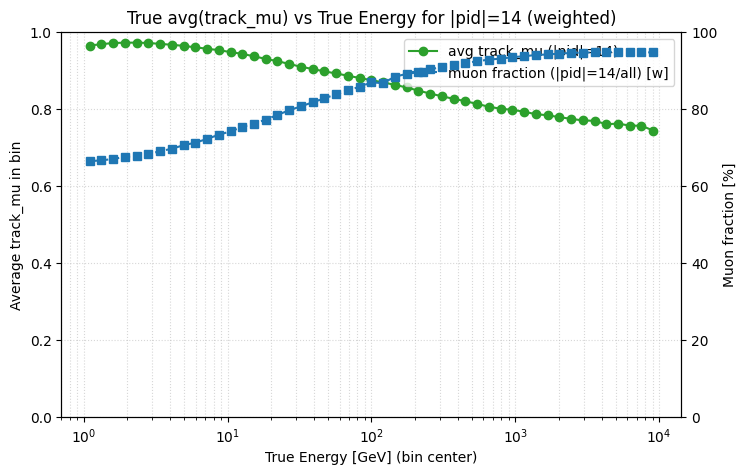

In [18]:
# True average track_mu vs true energy for muon neutrinos only (|pid| = 14)

# Filter to muon neutrinos in truth (|pid| = 14)
mu_mask_all = (np.abs(db_MC_neutrinos_cut['pid'].values) == 14)
e_true_mu = db_MC_neutrinos_cut.loc[mu_mask_all, 'energy'].to_numpy()
t_true_mu = db_MC_neutrinos_cut.loc[mu_mask_all, 'track_mu'].to_numpy()

# Use event weights if available, else fallback to unweighted
use_weight = 'event_weight' in globals() and isinstance(event_weight, np.ndarray) and event_weight.shape[0] == db_MC_neutrinos_cut.shape[0]
w_true_mu = event_weight[mu_mask_all] if use_weight else np.ones_like(e_true_mu, dtype=float)

# Establish energy binning (reuse prior energy_bins if present; otherwise derive from muon-neutrino energies)
try:
    energy_bins
except NameError:
    # Derive log-spaced bins from muon-neutrino true energies
    finite_e = e_true_mu[np.isfinite(e_true_mu)]
    if finite_e.size == 0:
        raise RuntimeError("No finite true energies found for |pid|=14.")
    e_min = max(finite_e.min(), 1e-6)
    e_max = finite_e.max()
    energy_bins = np.logspace(np.log10(e_min), np.log10(e_max), 50)

nb = len(energy_bins) - 1
energy_centers_mu = np.sqrt(energy_bins[:-1] * energy_bins[1:])

# Bin-average of track_mu (0/1) within each energy bin
idx = np.digitize(e_true_mu, energy_bins) - 1
mask = (
    (idx >= 0) & (idx < nb) &
    np.isfinite(e_true_mu) & np.isfinite(t_true_mu) & np.isfinite(w_true_mu)
)

sum_wt = np.bincount(idx[mask], weights=t_true_mu[mask] * w_true_mu[mask], minlength=nb)[:nb]
sum_w  = np.bincount(idx[mask], weights=w_true_mu[mask], minlength=nb)[:nb]
avg_track_mu = np.divide(sum_wt, sum_w, out=np.full(nb, np.nan, dtype=float), where=sum_w > 0)

# Muon fraction among all flavours in the same bins: |pid|=14 / (|pid| in {12,14,16})
e_all = db_MC_neutrinos_cut['energy'].to_numpy()
pid_abs_all = np.abs(db_MC_neutrinos_cut['pid'].to_numpy())
w_all = event_weight if use_weight else np.ones_like(e_all, dtype=float)
idx_all = np.digitize(e_all, energy_bins) - 1
mask_all = (idx_all >= 0) & (idx_all < nb) & np.isfinite(e_all) & np.isfinite(w_all)
mu_mask_bins = (pid_abs_all == 14) & mask_all
sum_w_mu  = np.bincount(idx_all[mu_mask_bins], weights=w_all[mu_mask_bins], minlength=nb)[:nb]
sum_w_tot = np.bincount(idx_all[mask_all],     weights=w_all[mask_all],     minlength=nb)[:nb]
frac_mu = np.divide(sum_w_mu, sum_w_tot, out=np.full(nb, np.nan, dtype=float), where=sum_w_tot > 0)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
line1, = ax.plot(energy_centers_mu, avg_track_mu, marker='o', linestyle='-', color='tab:green', label='avg track_mu (|pid|=14)')
ax.set_xscale('log')
ax.set_ylim(0, 1)
ax.set_xlabel('True Energy [GeV] (bin center)')
ax.set_ylabel('Average track_mu in bin')
ax.set_title(f"True avg(track_mu) vs True Energy for |pid|=14 ({'weighted' if use_weight else 'unweighted'})")
ax.grid(True, which='both', ls=':', alpha=0.5)

# Secondary y-axis for percentage of muon among all flavours
ax2 = ax.twinx()
line2, = ax2.plot(energy_centers_mu, frac_mu * 100.0, marker='s', linestyle='--', color='tab:blue', label=f"muon fraction (|pid|=14/all) {'[w]' if use_weight else '[uw]'}")
ax2.set_ylabel('Muon fraction [%]')
ax2.set_ylim(0, 100)

# Combined legend
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='best')

plt.show()


#CC goes down/NC goes up... while CC/NC should be relatively constant 

In [ ]:

# Define quark list and their (I3, Q) values
_quarks = {
    'u': {'I3':  0.5, 'Q':  2/3},
    'c': {'I3':  0.5, 'Q':  2/3},
    'd': {'I3': -0.5, 'Q': -1/3},
    's': {'I3': -0.5, 'Q': -1/3},
    'b': {'I3': -0.5, 'Q': -1/3},
    # top quark not included (threshold very high, negligible PDF in nucleon at relevant x)
}

def gL_gR_for_quark(q, sin2w):
    """Return (gL, gR) for quark q given sin^2(theta_W)."""
    I3 = _quarks[q]['I3']
    Q  = _quarks[q]['Q']
    gL = I3 - Q * sin2w
    gR = - Q * sin2w
    return gL, gR

def coupling_squared_sum(sin2w):
    """
    Compute S(sin2w) = sum_q w_q * (gL^2 + gR^2)
    If weights is None, use equal weights for each quark in _quarks.
    weights should be a dict mapping quark->weight (nonnegative).
    """
    S = 0.0
    for q in _quarks.keys():
        gL, gR = gL_gR_for_quark(q, sin2w)
        S += (gL**2 + gR**2)
    return S

def R_of_sin2w(sin2w, sin2w_ref=0.23126):
    """
    Return scaling factor R(sin2w) = S(sin2w) / S(sin2w_ref)
    where S = sum_q w_q (gL^2 + gR^2).
    """
    S_ref = coupling_squared_sum(sin2w_ref)
    S = coupling_squared_sum(sin2w)
    return S / S_ref

def scale_sigma_NC(sigma_NC_ref, sin2w, sin2w_ref=0.2229):
    """
    Scale a reference sigma_NC (scalar or numpy array) by R(sin2w).
    Returns scaled sigma_NC for same shape as sigma_NC_ref.
    """
    R = R_of_sin2w(sin2w, sin2w_ref=sin2w_ref)
    return np.array(sigma_NC_ref) * float(R), float(R)

#0.2229 from standard model 1- (Mw)/(Mz)^2 

[INFO] Resampled predictions for 36741821 events across 98 true bins using R=1.466 for NC boost.
[INFO] sin2w=0.001: applied R=1.466 for NC boost during resampling.
[INFO] Resampled predictions for 36741821 events across 98 true bins using R=1.441 for NC boost.
[INFO] sin2w=0.01: applied R=1.441 for NC boost during resampling.
[INFO] Resampled predictions for 36741821 events across 98 true bins using R=1.223 for NC boost.
[INFO] sin2w=0.1: applied R=1.223 for NC boost during resampling.
[INFO] Resampled predictions for 36741821 events across 98 true bins using R=0.988 for NC boost.
[INFO] sin2w=0.23126: applied R=0.988 for NC boost during resampling.
[INFO] Resampled predictions for 36741821 events across 98 true bins using R=0.9044 for NC boost.
[INFO] sin2w=0.3: applied R=0.9044 for NC boost during resampling.
[INFO] Resampled predictions for 36741821 events across 98 true bins using R=0.8157 for NC boost.
[INFO] sin2w=0.5: applied R=0.8157 for NC boost during resampling.
[INFO] Resa

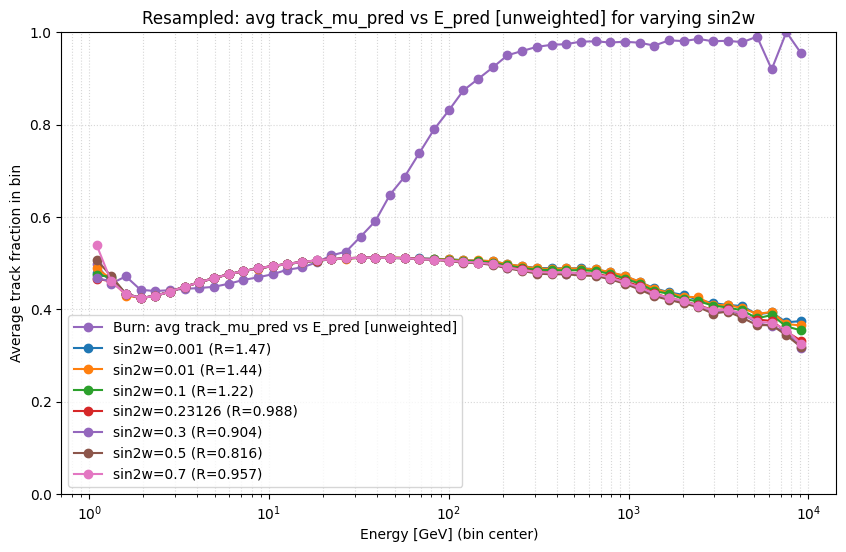

In [27]:
# Weighted TP/FP/TN/FN per true-energy bin
# If weights are provided, returns weighted sums; otherwise returns unweighted counts.
import numpy as np

def get_TPFPTNFN(energy_bins, df, weights=None):
    """
    Compute TP/FP/TN/FN per true-energy bin using truth labels (interaction_type, track_mu).
    Bin definition: (energy_bins[i], energy_bins[i+1]] (right-inclusive).
    Categories (kept as in original function intent):
      TP: interaction_type == 1 (CC)  and track_mu == 1 (track)
      FP: interaction_type == 2 (NC)  and track_mu == 1 (track)
      TN: interaction_type == 2 (NC)  and track_mu == 0 (cascade)
      FN: interaction_type == 1 (CC)  and track_mu == 0 (cascade)
    Returns four numpy arrays of length len(energy_bins)-1 with weighted sums.
    """
    e = df['energy'].to_numpy()
    it = df['interaction_type'].to_numpy()
    t  = df['track_mu'].to_numpy()

    if weights is None:
        w = np.ones_like(e, dtype=float)
    else:
        w = np.asarray(weights, dtype=float)
        if w.shape[0] != e.shape[0]:
            raise ValueError('weights must have same length as df')

    # Validity mask
    valid = np.isfinite(e) & np.isfinite(it) & np.isfinite(t) & np.isfinite(w)
    e = e[valid]
    it = it[valid]
    t  = t[valid]
    w  = w[valid]

    nb = len(energy_bins) - 1
    TP = np.zeros(nb, dtype=float)
    FP = np.zeros(nb, dtype=float)
    TN = np.zeros(nb, dtype=float)
    FN = np.zeros(nb, dtype=float)

    for i in range(nb):
        lo, hi = energy_bins[i], energy_bins[i+1]
        mask_bin = (e > lo) & (e <= hi)
        if not np.any(mask_bin):
            continue
        eb = e[mask_bin]
        itb = it[mask_bin]
        tb  = t[mask_bin]
        wb  = w[mask_bin]

        TP[i] = wb[(itb == 1) & (tb == 1)].sum()
        FP[i] = wb[(itb == 2) & (tb == 1)].sum()
        TN[i] = wb[(itb == 2) & (tb == 0)].sum()
        FN[i] = wb[(itb == 1) & (tb == 0)].sum()

    return TP, FP, TN, FN

# Build weighted lists using per-event weights (if available)
TP_list_w, FP_list_w, TN_list_w, FN_list_w = get_TPFPTNFN(energy_bins, db_MC_neutrinos_cut, weights=event_weight)

sin2w_values = [0.001, 0.01, 0.1, 0.2229, 0.3, 0.5, 0.7]
results = []

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(energy_centers, avg_burn_pred, marker='o', linestyle='-',  color='tab:purple', label='Burn: avg track_mu_pred vs E_pred [unweighted]')

for s in sin2w_values:
    new_TN_list, R = scale_sigma_NC(TN_list_w, s)
    new_db, R_used = resample_predictions_per_true_bin_weighted(db_MC_neutrinos_cut, energy_bins, true_track_edges,
                                               base_weights=event_weight, R_factor=R,
                                               rng_seed=None)

    e_pred_rs = new_db['energy_pred_resampled'].to_numpy()
    t_pred_rs = new_db['track_mu_pred_resampled'].to_numpy()
    idx_rs = np.digitize(e_pred_rs, energy_bins) - 1
    mask_rs = (idx_rs >= 0) & (idx_rs < len(energy_bins)-1) & np.isfinite(e_pred_rs) & np.isfinite(t_pred_rs)
    sum_t_rs = np.bincount(idx_rs[mask_rs], weights=t_pred_rs[mask_rs], minlength=len(energy_bins)-1)[:len(energy_bins)-1]
    cnt_rs   = np.bincount(idx_rs[mask_rs], minlength=len(energy_bins)-1)[:len(energy_bins)-1]
    avg_resampled = np.divide(sum_t_rs, cnt_rs, out=np.full(len(energy_bins)-1, np.nan, dtype=float), where=cnt_rs > 0)
    ax.plot(energy_centers, avg_resampled, marker='o', linestyle='-', label=f'sin2w={s} (R={R:.3g})')
    print(f"[INFO] sin2w={s}: applied R={R:.4g} for NC boost during resampling.")
    
ax.set_xscale('log')
ax.set_ylim(0, 1)
ax.set_xlabel('Energy [GeV] (bin center)')
ax.set_ylabel('Average track fraction in bin')
ax.set_title('Resampled: avg track_mu_pred vs E_pred [unweighted] for varying sin2w')
ax.grid(True, which='both', ls=':', alpha=0.5)
ax.legend()
plt.show()




